# Train Full Net

In this NB I tried modifying two things
1. the data is augmented by a random zoom-plus-flip-plus-rotate tranformation. 
2. the encoding layers of the NN are frozen.

Unfortuately my naive use of the data augmentation did no take into account the need to apply the same tranformation to masks. Still, something useful was learned: accuracy was 80% even when comparing an mask generated by a rotated, zoomed, possibly flipped image. Thus, much of the accuracy comes from the large swaths of constant class. Note that this sould be true of pet segmentation too. 

## 1) Data pipeline

In [4]:
import numpy as np
from glob import glob
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

## retrieve model
from tensorflow import keras
model = keras.models.load_model('saved_models/')

## even a pre-trained model needs data:

# 1. Sort paths to files

IMAGE_SIZE = 224
path = 'beachlitter/'
images = sorted(glob(os.path.join(path, "images/*.jpg"))) # list of strings
masks = sorted(glob(os.path.join(path, "maskpngs/*.png"))) 

from sklearn.model_selection import train_test_split

def sort_paths(path, split=0.1):
    # PATH = "gs://dmcherney/beachlitter/"
    # glob(file_pattern) gives a list of strings satisfying the pattern
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "maskpngs/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    
    #shuffle with the same random seed to make sure masks stay with images.
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = sort_paths(path)

#2 functions to read images: path -> PIL -> array

def read_image(path): #takes in a path, gives out a np array
    path = path.decode() # neede because this function is in a tf pipe
    # open image
    im = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # image to tensor
    im = tf.keras.utils.img_to_array(im, data_format=None, dtype='float32')
    # normalize image
    im = im/255.
    return im

def read_mask(path):
    path = path.decode() # neede because this function is in a tf pipe
    # open mask
    ma = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # mask to tensor
    ma = tf.keras.utils.img_to_array(ma, data_format=None, dtype='float32')
    # change catagory numbers from 1 to 8 into 0 to 7
    ma[:,:,0] -= 1
    # one hot encode
    ma = to_categorical(ma[:,:,0],num_classes=8, dtype='float32')
    return ma

# arrays to tensorflow tensors:
def tf_parse(x, y): # takes in 2 paths, not lists
    def _parse(x, y): # takes in 2 paths
        x = read_image(x) 
        y = read_mask(y)
        return x, y # gives out 2 np.arrays

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32]) #takes in 2 paths, gives out 2 tf.tesors
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3]) # seems redundant, but for now it is bouble check
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 8])
    return x, y # tf.tesors 

# 3 organize data into tf dataset of tf tensors
def tf_dataset(x, y, batch=8): #takes in x : list of paths, y : list of paths
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

train_dataset = tf_dataset(train_x, train_y) # input: lists of filenames . Output: to batched tf datasets of parsed images
valid_dataset = tf_dataset(valid_x, valid_y)


In [5]:
# network architecture and fitting tools
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.callbacks import TensorBoard 
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import datetime


## 2) Modify the model to include randomized data augmentation

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential([
                                    layers.RandomFlip("horizontal",name='hi'),
                                    layers.RandomRotation(0.1),
                                    layers.RandomZoom(0.2)])

In [24]:
# making the pre trained NN not trainable/fixed 
# inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
# randomized_inputs = data_augmentation(inputs)
# encoder = MobileNetV2(input_tensor=randomized_inputs, weights="imagenet", include_top=False, alpha=0.35)
# encoder.trainable = False
# encoder.summary(show_trainable=True)

In [25]:
from tensorflow.keras.applications import MobileNetV2 
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    randomized_inputs = data_augmentation(inputs)
    
    # the pre-trained encoder
    encoder = MobileNetV2(input_tensor=randomized_inputs, 
                          weights="imagenet", # instead of randomized initial weights
                          include_top=False, # to fully connected softmax layer off. 
                          alpha=0.35) # proportionally decrease the number of filters in each layer. see paper.
    encoder.trainable = False
    skip_connection_names = ["input_image", "block_1_expand_relu", 
                             "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    # output of encoder is 16x16 
    
    # the decoder follows
    f = [16, 32, 48, 64] # the numbers of filters to use in skips traveling UP the U 
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    # output layer:
    # old version had one class, thus one filter:
    # x = Conv2D(1, (1, 1), padding="same")(x)
    # x = Activation("sigmoid")(x)
    x = Conv2D(8, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    
    model = Model(inputs, x) # object created
    return model # object returned

model = model()
LR = 1e-4 #learning rate
opt = tf.keras.optimizers.Nadam(LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [26]:
model.summary(show_trainable=True)

Model: "model_5"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               N          
                                )]                                                                           
                                                                                                             
 sequential_3 (Sequential)      (None, 224, 224, 3)  0           ['input_image[0][0]']            N          
                                                                                                             
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['sequential_3[2][0]']           N          
                                )                                                                      

## 3) Train with the fit method

In [39]:
# options first:
LR = 1e-4 #learning rate
opt = tf.keras.optimizers.Nadam(LR)
BATCH = 8 
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # for tensorboard logs
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    # EarlyStopping(monitor='val_loss', 
    #               patience=5, 
    #               restore_best_weights=True # lets me save the model.
    #                      ),
    TensorBoard(log_dir=log_dir, histogram_freq=1, #for histogram computation each epoc 
                              )
]

#call fit
res = model.fit(
    train_dataset, # this actas as both X and y
    validation_data=valid_dataset,
    epochs = 48,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/48
350/350 [==============================] - 558s 2s/step - loss: 0.9787 - accuracy: 0.7270 - val_loss: 0.8329 - val_accuracy: 0.7749 - lr: 1.0000e-04
Epoch 2/48
350/350 [==============================] - 580s 2s/step - loss: 0.8825 - accuracy: 0.7453 - val_loss: 0.7516 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 3/48
350/350 [==============================] - 567s 2s/step - loss: 0.8078 - accuracy: 0.7616 - val_loss: 0.6900 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 4/48
350/350 [==============================] - 575s 2s/step - loss: 0.7571 - accuracy: 0.7712 - val_loss: 0.6747 - val_accuracy: 0.8092 - lr: 1.0000e-04
Epoch 5/48
350/350 [==============================] - 575s 2s/step - loss: 0.7209 - accuracy: 0.7783 - val_loss: 0.6265 - val_accuracy: 0.8272 - lr: 1.0000e-04
Epoch 6/48
350/350 [==============================] - 607s 2s/step - loss: 0.6963 - accuracy: 0.7827 - val_loss: 0.6052 - val_accuracy: 0.8213 - lr: 1.0000e-04
Epoch 7/48
350/350 [====================

In [41]:
1+1


2

In [40]:
1+2

3

In [42]:
# import pandas as pd
# scores= pd.DataFrame(data=res.history)
scores

,loss,accuracy,val_loss,val_accuracy,lr
0,1.450202,0.606081,1.213300,0.709890,0.0001
1,1.122983,0.695922,0.919184,0.769601,0.0001


In [43]:
scores = pd.concat([scores,pd.DataFrame(data=res.history)])
scores

,loss,accuracy,val_loss,val_accuracy,lr
0,1.450202,0.606081,1.213300,0.709890,1.000000e-04
1,1.122983,0.695922,0.919184,0.769601,1.000000e-04
0,0.978668,0.726972,0.832907,0.774889,1.000000e-04
1,0.882526,0.745291,0.751570,0.802365,1.000000e-04
2,0.807813,0.761615,0.689994,0.801884,1.000000e-04
3,0.757135,0.771211,0.674660,0.809212,1.000000e-04
4,0.720943,0.778257,0.626456,0.827163,1.000000e-04
5,0.696332,0.782716,0.605159,0.821280,1.000000e-04
6,0.677193,0.786322,0.586736,0.822375,1.000000e-04
7,0.661110,0.789802,0.568635,0.825163,1.000000e-04


In [47]:
scores.reset_index(inplace=True)

In [6]:
model.save('saved_models/')

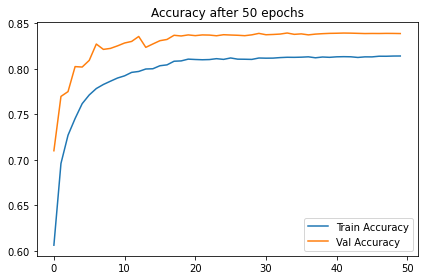

In [48]:
plt.plot(scores['accuracy'], label='Train Accuracy')
plt.plot(scores['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title(f'Accuracy after {len(scores)} epochs')
plt.tight_layout();

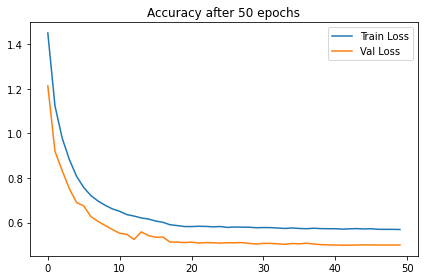

In [49]:
plt.plot(scores['loss'], label='Train Loss')
plt.plot(scores['val_loss'], label='Val Loss')
plt.legend()
plt.title(f'Accuracy after {len(scores)} epochs')
plt.tight_layout();

In [51]:
%load_ext tensorboard


In [52]:
%tensorboard --logdir logs/fit

In [53]:
%%time
1+1

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.4 µs


2